In [191]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

In [192]:
pd.options.display.float_format = '{:.2f}'.format

In [193]:
dates_to_visualize = [
                                                                                            "2018-09", "2018-10", "2018-11", "2018-12",
    "2019-01", "2019-02", "2019-03", "2019-04", "2019-05", "2019-06", "2019-07", "2019-08", "2019-09", "2019-10", "2019-11", "2019-12", 
    "2020-01", "2020-02", "2020-03", "2020-04", "2020-05", "2020-06", "2020-07", "2020-08", "2020-09", "2020-10", "2020-11", "2020-12",
    "2021-01", "2021-02", "2021-03", "2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12",
    "2022-01", "2022-02", "2022-03", "2022-04", "2022-05", "2022-06", "2022-07", "2022-08", "2022-09", "2022-10", "2022-11", "2022-12",
    "2023-01", "2023-02",
    # "2024-02",
]

In [194]:
available_data_files = list(Path("../data/httparchive_metrics/nel_collector_provider_usage").glob("*.parquet"))

used_data_files = list(filter(lambda file: file.stem in dates_to_visualize, available_data_files))
used_data_files

[WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2018-09.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2018-10.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2018-11.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2018-12.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-02.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-03.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-04.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-05.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-06.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-07.parquet'),
 WindowsPath('../data/httparchive_metrics/nel_collector_provider_usage/2019-08.parquet'),
 WindowsPa

### Aggregate result to visualize


In [195]:
from results.result_utils import date_to_text_format, concat_data_from_files

result = concat_data_from_files(used_data_files)

result['date_formatted'] = result['date'].map(date_to_text_format)

result['as_primary'] = result['as_primary'].astype('UInt32')
result['as_secondary'] = result['as_secondary'].astype('UInt32')
result['among_fallback'] = result['among_fallback'].astype('UInt32')

result

,date,providers,as_primary,share_as_primary,as_secondary,share_as_secondary,among_fallback,date_formatted
0,2018-09,bingparachute.com,2,100.00,0,0.00,0,Sep 2018
0,2018-10,bingparachute.com,4,40.00,0,0.00,0,Oct 2018
1,2018-10,report-uri.com,3,30.00,0,0.00,0,Oct 2018
2,2018-10,seloc.org,2,20.00,0,0.00,0,Oct 2018
3,2018-10,3genlabs.net,1,10.00,0,0.00,0,Oct 2018
...,...,...,...,...,...,...,...,...
208,2023-02,darknetlive.com,0,0.00,0,0.00,0,Feb 2023
209,2023-02,noawildschut.com,0,0.00,0,0.00,0,Feb 2023
210,2023-02,mokyun.net,0,0.00,0,0.00,0,Feb 2023
211,2023-02,djeso7fl84a7m.cloudfront.net,0,0.00,0,0.00,0,Feb 2023


### Top 5 Primary Collector Providers per month


In [196]:
top_5_data = result[result.index < 5][['date', 'providers', 'as_primary', 'share_as_primary']]

count_by_date = result.groupby(['date'])['as_primary'].agg(lambda group: len([x for x in group if x > 0]))
top_5_data['count'] = top_5_data['date'].map(count_by_date)

top_5_data = top_5_data.reindex(columns=['date', 'count', 'providers', 'as_primary', 'share_as_primary'])
top_5_data['date'] = top_5_data['date'].map(date_to_text_format)
# top_5_data.groupby(['date', 'count', 'providers']).first()
top_5_data.sort_values(['date', 'share_as_primary'], ascending=[True, False])

,date,count,providers,as_primary,share_as_primary
0,Apr 2019,16,shopifycloud.com,74155,99.42
1,Apr 2019,16,report-uri.com,357,0.48
2,Apr 2019,16,3gl.net,21,0.03
3,Apr 2019,16,uriports.com,14,0.02
4,Apr 2019,16,gvt2.com,8,0.01
...,...,...,...,...,...
0,Sep 2022,163,cloudflare.com,2012617,98.16
1,Sep 2022,163,cafe24.com,19220,0.94
2,Sep 2022,163,office.net,5293,0.26
3,Sep 2022,163,dz8aopenkvv6s.cloudfront.net,2513,0.12


### Top 5 Secondary Collector Providers per month


In [197]:
secondaries = result[['date', 'providers', 'as_secondary', 'share_as_secondary']]
secondaries = secondaries[secondaries['as_secondary'] > 0]

top_5_data = pd.DataFrame()
for month in dates_to_visualize:
    monthly_data = secondaries[secondaries['date'] == month]
    
    monthly_data.reset_index(drop=True, inplace=True)
    top_5_data = pd.concat([top_5_data, monthly_data])

top_5_data = top_5_data[top_5_data.index < 5]

count_by_date = result.groupby(['date'])['as_secondary'].agg(lambda group: len([x for x in group if x > 0]))
top_5_data['count'] = top_5_data['date'].map(count_by_date)

top_5_data = top_5_data.reindex(columns=['date', 'count', 'providers', 'as_secondary', 'share_as_secondary'])
top_5_data['date'] = top_5_data['date'].map(date_to_text_format)
# # top_5_data.groupby(['date', 'count', 'providers']).first()
top_5_data.sort_values(['date', 'share_as_secondary'], ascending=[True, False]).reset_index(drop=True)

,date,count,providers,as_secondary,share_as_secondary
0,Apr 2019,1,gvt2.com,8,100.00
1,Apr 2020,1,gvt2.com,15,100.00
2,Apr 2021,4,fastlylabs.com,8335,98.29
3,Apr 2021,4,yandex.net,127,1.50
4,Apr 2021,4,gvt2.com,15,0.18
...,...,...,...,...,...
155,Sep 2022,5,fastlylabs.com,102,33.66
156,Sep 2022,5,yandex.net,96,31.68
157,Sep 2022,5,gvt2.com,76,25.08
158,Sep 2022,5,ecsvc.net,26,8.58


### Top 5 Collector Providers by occurrence

In [198]:
occurrence_data = result[['date', 'providers', 'as_primary', 'as_secondary', 'among_fallback']]

all_occurrences = pd.DataFrame()
for month in dates_to_visualize:
    monthly_data = occurrence_data[occurrence_data['date'] == month].copy()
    
    monthly_data['total_occurrences'] = monthly_data['as_primary'] + monthly_data['as_secondary'] + monthly_data['among_fallback']
    monthly_data.drop(columns=['as_primary', 'as_secondary', 'among_fallback'], inplace=True)
    
    monthly_data['date'] = monthly_data['date'].map(date_to_text_format)
    
    monthly_data.reset_index(drop=True, inplace=True)
    
    all_occurrences = pd.concat([all_occurrences, monthly_data])
    
top_5_data = all_occurrences[all_occurrences.index < 5]
top_5_data

,date,providers,total_occurrences
0,Sep 2018,bingparachute.com,2
0,Oct 2018,bingparachute.com,4
1,Oct 2018,report-uri.com,3
2,Oct 2018,seloc.org,2
3,Oct 2018,3genlabs.net,1
...,...,...,...
0,Feb 2023,cloudflare.com,2208358
1,Feb 2023,cafe24.com,21858
2,Feb 2023,freshedge.net,7693
3,Feb 2023,office.net,7444


#### The TOP provider over the analyzed time

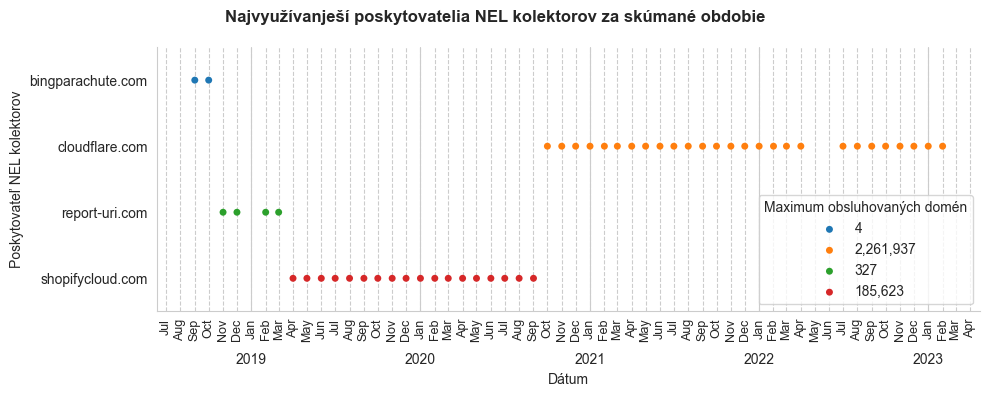

In [199]:
to_plot = all_occurrences.copy()
to_plot = to_plot[to_plot.index == 0]

to_plot['date_fmt'] = to_plot['date'].map(lambda date: pd.to_datetime(date))
to_plot['providers'] = to_plot['providers'].astype('category')

sns.set_style('whitegrid')
g = sns.catplot(to_plot, x='date_fmt', y='providers', hue='providers', kind="swarm", height=4, aspect=2.5)
g.fig.suptitle('Najvyužívanješí poskytovatelia NEL kolektorov za skúmané obdobie', fontweight='bold')
ax = g.axes[0][0]

# sns.barplot(to_plot, x='date_fmt', y='total_occurrences', ax=ax, hue='providers')

ax.xaxis.remove_overlapping_locs = False

years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n\n%Y"))

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmt)

ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)

plt.grid(True, which='minor', linestyle='--',)

max_employment = to_plot.groupby(['providers'], observed=True).agg(max=('total_occurrences', 'max')).values
ax.legend(list(map(lambda val: '{:,.0f}'.format(val[0]), max_employment)), title='Maximum obsluhovaných domén')

ax.set(xlabel='Dátum', ylabel='Poskytovateľ NEL kolektorov')

plt.tight_layout()
plt.savefig('graphs/httparchive_nel_collector_provider_top_1_over_time.pdf')

#### GRAPH - Number of collector providers over the time

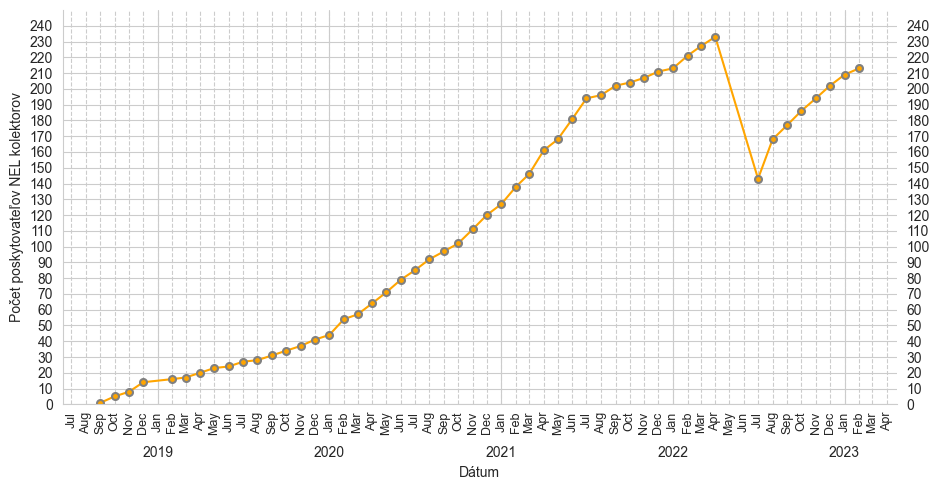

In [200]:
to_plot = all_occurrences.copy()
to_plot = to_plot.groupby(['date'], as_index=False).agg(pcount=('providers', 'count'))


to_plot['date_fmt'] = to_plot['date'].map(lambda date: pd.to_datetime(date))
to_plot.drop(columns=['date'], inplace=True)
to_plot = to_plot.sort_values(by=['date_fmt'])
to_plot.reset_index(inplace=True)
to_plot = to_plot.reindex(columns=['date_fmt', 'pcount']) 

g = sns.relplot(to_plot, x='date_fmt', y='pcount', kind='line', color='orange', height=5, aspect=1.9)
ax = g.axes[0][0]

ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)
ax.xaxis.remove_overlapping_locs = False
years = mdates.YearLocator()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(mdates.DateFormatter("\n\n%Y"))

months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(months_fmt)

ax.tick_params(axis='x', which="minor", rotation=90, labelsize=9)


ax.set(xlabel='Dátum', ylabel='Počet poskytovateľov NEL kolektorov')

plt.grid(True, which='minor', linestyle='--',)
ax.set(ylim = (0,250))

ax.yaxis.set_major_locator(ticker.FixedLocator(np.arange(0, 250, 10)))
ax.tick_params(labelright=True)

ax.lines[0].set_marker('.')
ax.lines[0].set_markersize(10)
ax.lines[0].set_markeredgecolor('gray')
ax.lines[0].set_markeredgewidth(1.5)

plt.tight_layout()
plt.savefig('graphs/httparchive_nel_collector_provider_count.pdf')


#### GRAPH - Latest stats for collector providers

In [213]:
pd.options.display.float_format = '{:.5f}'.format

to_plot = all_occurrences.copy()
to_plot['date_fmt'] = to_plot['date'].map(lambda date: pd.to_datetime(date))
to_plot.drop(columns=['date'], inplace=True)
to_plot = to_plot.sort_values(by=['date_fmt'])
to_plot.reset_index(inplace=True)
to_plot = to_plot.reindex(columns=['date_fmt', 'providers', 'total_occurrences'])


latest_data = to_plot[to_plot['date_fmt'] == to_plot['date_fmt'].max()].copy()
latest_data['total_employment'] = latest_data['total_occurrences'].sum()
latest_data['provider_share'] = latest_data['total_occurrences'] / latest_data['total_employment']
latest_data

# FIX the dates
# Plot 10 most popular collector providers with their stats 
# OR - create a table


,date_fmt,providers,total_occurrences,total_employment,provider_share
5610,2023-02-01,todoist.net,1,2259471,0.00000
5611,2023-02-01,healofy.com,1,2259471,0.00000
5612,2023-02-01,gulper.io,1,2259471,0.00000
5613,2023-02-01,gameintel.io,1,2259471,0.00000
5614,2023-02-01,loggly.com,1,2259471,0.00000
...,...,...,...,...,...
5818,2023-02-01,jcvignoli.com,2,2259471,0.00000
5819,2023-02-01,exat.co.th,2,2259471,0.00000
5820,2023-02-01,impervademo.com,2,2259471,0.00000
5821,2023-02-01,focoesquadriasemaluminio.com.br,2,2259471,0.00000


### NEL Collector Providers employed by N domains


In [202]:
from results.result_utils import get_first_or_0

employment_result = pd.DataFrame({}, index=[
    '1',
    '2',
    '3-10',
    '11-100',
    '101-1K',
    'More',
])

for date in dates_to_visualize:
    month_collector_data = result[result['date'] == date].copy()
    
    month_data_col = []
    
    # month_result['1']
    next_val = month_collector_data[month_collector_data['as_primary'] == 1].count()
    month_data_col.append(get_first_or_0(next_val))
    
    # month_result['2'] 
    next_val = month_collector_data[month_collector_data['as_primary'] == 2].count()
    month_data_col.append(get_first_or_0(next_val))

    # month_result['3-10']
    next_val = month_collector_data[(month_collector_data['as_primary'] >= 3) & (month_collector_data['as_primary'] <= 10)].count()
    month_data_col.append(get_first_or_0(next_val))
    
    # month_result['3-10']
    next_val = month_collector_data[(month_collector_data['as_primary'] >= 11) & (month_collector_data['as_primary'] <= 100)].count()
    month_data_col.append(get_first_or_0(next_val))
    
    # month_result['3-10']
    next_val = month_collector_data[(month_collector_data['as_primary'] >= 101) & (month_collector_data['as_primary'] <= 1000)].count()
    month_data_col.append(get_first_or_0(next_val))
    
    # month_result['3-10']
    next_val = month_collector_data[month_collector_data['as_primary'] >= 1001].count()
    month_data_col.append(get_first_or_0(next_val))
    
    
    employment_result[date_to_text_format(date)] = month_data_col
    
employment_result

,Sep 2018,Oct 2018,Nov 2018,Dec 2018,Jan 2019,Feb 2019,Mar 2019,Apr 2019,May 2019,Jun 2019,...,May 2022,Jun 2022,Jul 2022,Aug 2022,Sep 2022,Oct 2022,Nov 2022,Dec 2022,Jan 2023,Feb 2023
1,0,1,3,3,0,3,4,7,7,8,...,0,0,59,76,78,82,84,88,89,90
2,1,1,2,0,0,2,2,1,0,1,...,0,0,25,24,25,27,23,25,19,19
3-10,0,2,2,5,0,4,3,4,5,3,...,0,0,19,23,26,21,23,24,24,27
11-100,0,0,0,1,0,1,2,2,2,2,...,0,0,18,15,14,15,14,13,15,13
101-1K,0,0,1,1,0,1,1,1,1,1,...,0,0,13,12,12,11,11,11,10,10
More,0,0,0,0,0,0,0,1,1,1,...,0,0,5,9,8,10,10,10,10,10


### Total number of collectors found during the analysed time period


In [203]:
len(result['providers'].unique())

289